# Implementation of Mirror Descent 


#### *pymdptoolbox* is a python library from which MDP examples can be imported </br>
##### Documentation of *pymdptoolbox* : https://pymdptoolbox.readthedocs.io/en/latest/api/mdptoolbox.html




In [1]:
!pip install pymdptoolbox   #Install pymdptoolbox within the code

In [2]:
!pip install cvxopt # A python library to solve linear and quadratic optimization problems

In [3]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

In [4]:
class HiddenPrints:       #To suppress print statements during execution of library function
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Class MarkovDP 


In [5]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        self.rewards2              = np.zeros((s,a))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards2 = np.random.rand(self.num_state,self.num_action)
        for a in self.actions:
            for s in self.states:
                for s1 in self.states:
                    self.rewards[a][s][s1] = self.rewards2[s][a]

## Policy Iteration

In [6]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

## Find transition matrix P(s'|s) under policy $\pi$

In [7]:
def P_matrix(env,pi):
    
    # Compute Transition probabilities P(s,s') using P(s'| s,a ) and pi( a|s ) : Matrix of size |s| x |s|
    P=np.empty((env.num_state,env.num_state),dtype=float)
    P=np.multiply(np.reshape(pi[:,0],(-1,1)),env.transitions[0][:][:])
    for a in range(1,env.num_action):
        P=P+np.multiply(np.reshape(pi[:,a],(-1,1)),env.transitions[a][:][:])
    return P
        

## Find C<sup>$\pi$</sup> : $\Sigma\pi$[s][a] x reward[s][a]

In [8]:
def C_pi(env,pi):
    C=np.sum(np.multiply(env.rewards2,pi),axis=1)
    return C

## Projection operator : reduced to a quadratic optimization problem
#### Finding a point in the solution space that is closest to the given point

In [9]:
def projection(env,x):
    P = 2*matrix(np.identity(env.num_action))
    q = -2*matrix(x)
    G = -1*matrix(np.identity(env.num_action))
    h = matrix(np.zeros(env.num_action))
    A = matrix(np.ones(env.num_action), (1,env.num_action))
    b = matrix(1.0)
    with HiddenPrints():
        sol=solvers.qp(P, q, G, h, A, b)
    proj= np.reshape(np.array(sol['x']),(1,-1))
    return proj


## Evaluate Q under policy $\pi$<sub>t</sub>

In [10]:
def evaluate_q(env, pi, gamma, V):
    Q = np.zeros((env.num_state,env.num_action))
    for s in env.states:
        for a in env.actions:
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            Q[s][a] = np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    return Q

## Policy Update :PPG

In [11]:
def ppg_update(env,pi,Q,t_k):
    for s in env.states:
        pi[s] = pi[s]-t_k*Q[s]
        pi[s] = projection(env,pi[s])
    return pi
      



## Policy Update :NE-TRPO

In [13]:
def ne_trpo_update(env,pi,Q,t_k):
    X=np.empty((env.num_state,env.num_action),dtype=float)
    for s in env.states:
        for a in env.actions:
            X[s][a]= np.exp(-t_k*Q[s][a])
        X[s]=X[s]/np.sum(np.multiply(X[s],pi[s]))
    pi=np.multiply(pi,X)

    return pi



## Mirror Descent : Constant Step Size

### PPG Update

In [14]:
def trpo_ppg_cstep(env,gamma,iterations,step_size,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action 
    history=list() 
    t_k = -step_size
    for i in range(0,iterations):
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        t=(V_rho_optimal-np.dot(rho,V))

        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ppg_update(env,pi,Q,t_k)
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))

    return pi,V,history
        




### NE-TRPO Update

In [15]:
def trpo_ne_cstep(env,gamma,iterations,step_size,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action
    history=list()
    t_k = -step_size
    for i in range(0,iterations):
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        t=(V_rho_optimal-np.dot(rho,V))
        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ne_trpo_update(env,pi,Q,t_k)
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))

    return pi,V,history



## Mirror Descent : Time-variant Step Size

### PPG Update

In [16]:
def trpo_ppg_vstep(env,gamma,iterations,alpha,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action  
    history=list()
    t_k = -1
    for i in range(0,iterations):
        if i==0:
            pass
        elif i%10==0:
            t_k = 1/(np.power(i,alpha))
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        t=(V_rho_optimal-np.dot(rho,V))
        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ppg_update(env,pi,Q,t_k)
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))

    return pi,V,history

        




### NE-TRPO Update

In [17]:
def trpo_ne_vstep(env,gamma,iterations,alpha,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action
    history=list()
    t_k = -1 
    for i in range(0,iterations):
        if i==0:
            pass
        elif i%10==0:
            t_k = 1/(np.power(i,alpha))
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        t=(V_rho_optimal-np.dot(rho,V))
        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ne_trpo_update(env,pi,Q,t_k)

    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))
    return pi,V,history





## Plot log(V<sup>*</sup> - V<sup>t</sup>) vs log(t)

In [41]:
def plot_log(history,iterations,l):
    
    #x=np.array(range(0,iterations))
    x=np.log(np.array(range(0,iterations)))
    y=np.log(np.array(history)[:])

    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('log(t)', fontsize=12)
    plt.ylabel('log(V_opt-V(t))', fontsize=12)
    plt.plot(x,y,color='blue',label=l) 
    plt.title('Mirror Descent',fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

## Plot log(V<sup>*</sup> - V<sup>t</sup>) vs t

In [42]:
def plot_antilog(history,iterations,l):
    
    x=np.array(range(0,iterations))
    #x=np.log(np.array(range(0,iterations)))
    y=np.log(np.array(history)[:])

    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('log(V_opt-V(t))', fontsize=12)
    plt.plot(x,y,color='blue',label=l) 
    plt.title('Mirror Descent',fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

## Example 1

In [43]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=3
a=2
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R

In [44]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
rho= np.ones(env.num_state)/env.num_state

start_time = time.time()
V_optimal_policy,pi_optimal_policy = policy_iteration(env, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.017290830612182617 seconds ---


In [45]:
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

In [46]:
V_rho_optimal

5.522102858184402

In [47]:
V_optimal_policy

array([[5.66972692],
       [5.26496607],
       [5.63161558]])

In [48]:
iterations = 100
step_size = 0.001
pi_ppg_cstep,V_ppg_cstep,history_ppg_cstep = trpo_ppg_cstep(env,gamma,iterations,step_size,V_rho_optimal)

Iterations Completed
--- 0.3524308204650879 seconds ---


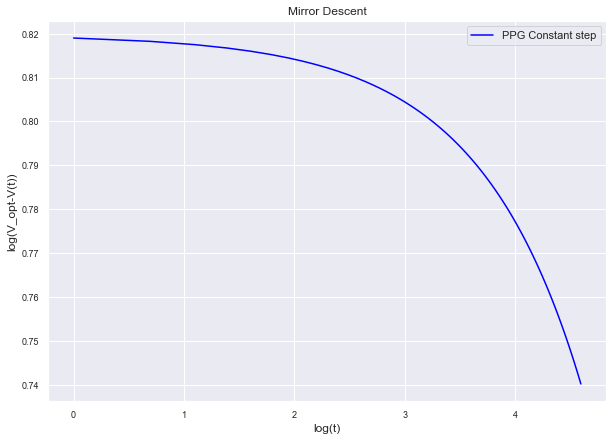

In [49]:
plot_log(history_ppg_cstep,iterations,'PPG Constant step')

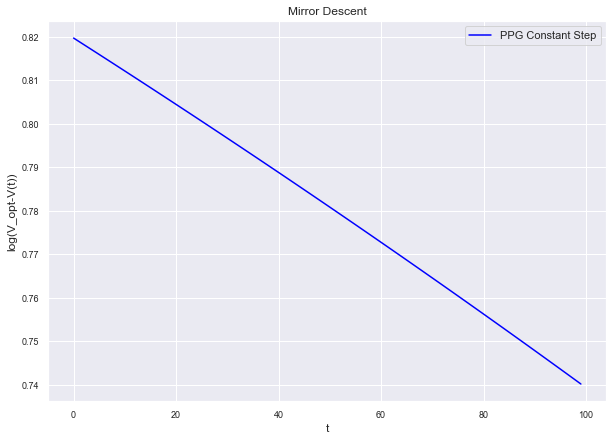

In [50]:
plot_antilog(history_ppg_cstep,iterations,'PPG Constant Step')

In [51]:
iterations = 120
step_size = 0.001
pi_ne_cstep,V_ne_cstep,history_ne_cstep = trpo_ne_cstep(env,gamma,iterations,step_size,V_rho_optimal)

Iterations Completed
--- 0.06634187698364258 seconds ---


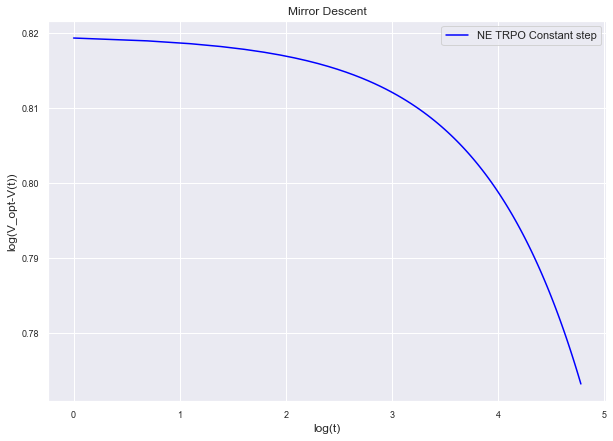

In [52]:
plot_log(history_ne_cstep,iterations,'NE TRPO Constant step')

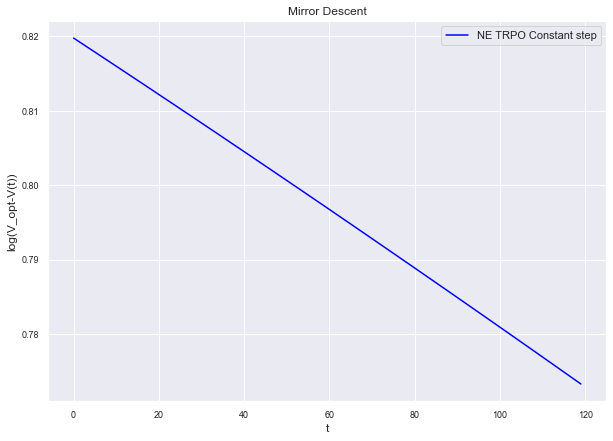

In [53]:
plot_antilog(history_ne_cstep,iterations,'NE TRPO Constant step')